In [1]:
import os
os.environ["JAX_ENABLE_X64"] = "True"
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import sys
import pandas as pd
from matplotlib import cm
import matplotlib as mp
import matplotlib.colors as mcolors
import scipy.special as sc
import scipy.optimize as so
from matplotlib.colors import LinearSegmentedColormap

In [50]:
def exp_Ansatz(x, k, d, d0):
    # Ensure x is a numpy array
    x = np.array(x, dtype=float)
    d_aux =d * x + d0
    prob = np.ones_like(x)  # Initialize an array for probabilities
    
    # Handle each element in x independently due to range(1, x_i + 1)
    for i, x_i in enumerate(x):
        for j in range(1, int(x_i) + 1):  # Loop from 1 to x_i (inclusive)
            prob[i] *= (d_aux[i] + 1 - j) / (j * 2 ** (d_aux[i] / x_i))
    
    return prob*k



def Ansatz(x, k, d, d0):
    
    EE=2**(d*x+d0)
    AA=k*sc.binom(d*x+d0,x*L)/EE     
    return AA
    #A=sc.gammaln(d*x+d0 + 1) - sc.gammaln(x*L + 1) - sc.gammaln(d*x+d0 - x*L + 1)-np.log(2)*(d*x+d0)

    #return np.exp(A,dtype=np.float64)
    
    
def log_Ansatz(x, k, d, d0):
    
    A=np.log(k)+sc.gammaln(d*x+d0 + 1) - sc.gammaln(x*L*W + 1) - sc.gammaln(d*x+d0 - x*L*W + 1)-np.log(2)*(d*x+d0)
    return A
    
    
def logKL(X,Y):
    return sum(map(lambda x: x[0]*np.log(x[0]/x[1]),zip(X,Y)))

def bounds(x,L):
    
    eps=10**(-6)
    #print("x",len(x))
    aux=np.array(x[0:int(L/2)])
    #print(aux.argmax())
    max=aux.argmax()
    if max<int(L/2):
        return max
    else:
        return int(L/2)-1


def initial_guess(x,L):
    eps=10**(-10)
    maxi=bounds(x,L)
    print(maxi)
    delta_left=maxi

    while delta_left>0 and x[delta_left]>eps:
        delta_left-=1
    delta_left+=1
    delta_right=maxi
    while delta_right<int(L*0.48) and x[delta_right]>eps:
        delta_right+=1
    delta_right-=1

    return [delta_left,maxi,delta_right]


def d(r,d0,d1,d2):
    return d0+r*d1+d2*(r**2)

def der_d(r,d0,d1,d2):
    return d1+2*r*d2

def grad_KL(r,d0,d1,d2):
    dr=d(r,d0,d1,d2)
    return -(sc.digamma(dr+1)-sc.digamma(dr-r*L+1)-dr/2)
    
def av_min(P,x,d0,d1,d2,n):
    sum=0
    for p in range(len(P)):
        aux=P[p]*grad_KL(x[p],d0,d1,d2)
        sum+=P[p]*grad_KL(x[p],d0,d1,d2)*(float(x[p])*1.0)**n
    return sum


def opt_step(P,x,k,d0,d1,d2,alp):
    
    
    d0_new=d0-alp*av_min(P,x,d0,d1,d2,0)
    d1_new=d1-alp*av_min(P,x,d0,d1,d2,1)
    d2_new=d2-alp*av_min(P,x,d0,d1,d2,2)
    k_new=k+alp*np.sum(P)/k
    
    return [k_new,d0_new,d1_new,d2_new]

def optimizer(P,k,d0,d1,d2,alp,N,alp_I,alp_F):
    
    KL=[]
    x=np.arange(alp_I,alp_F,1)/L
    k_aux=k
    d0_aux=d0
    d1_aux=d1
    d2_aux=d2
    print("initial",k,d0,d1,d2)
    for i in range(N):
        #print(d0_aux,d1_aux,d2_aux)
        aux=opt_step(P,x,k_aux,d0_aux,d1_aux,d2_aux,alp)
        k_aux=aux[0]
        d0_aux=aux[1]
        d1_aux=aux[2]
        d2_aux=aux[3]
        Y=Ansatz(x,k,d0_aux,d1_aux)
        KL.append(logKL(P,Y))
    print("d0","d1","d2")
    print(k_aux,d0_aux,d1_aux,d2_aux)
    return [KL,[k_aux,d0_aux,d1_aux,d2_aux]]
    

[0, 1, 2]
48
[48, 48, 47] par


ValueError: `ydata` must not be empty!

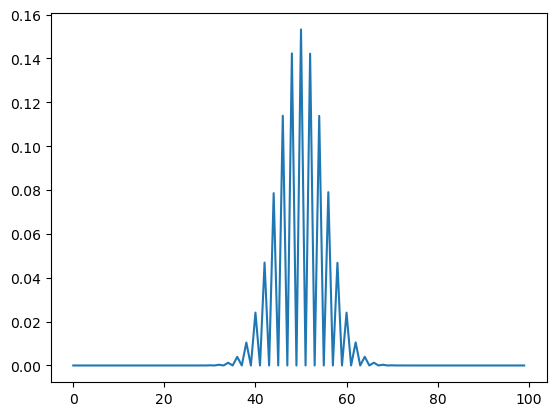

In [55]:
l=[100,200]
W=1
GI=90
GF=110
dG=10
NR=1000
NS=1000
n_mean=10
delta=0
start=0
dx=0.01
norm = mcolors.Normalize(vmin=np.abs(l[0]), vmax=np.abs(l[len(l)-1]))

G=[i for i in range(GI,GF+dG,dG)]
colors = [(0.0, 'yellow'),(0.25, "green"),(0.5, 'blue'),(0.75,"brown"),(1.0, 'red')]
# Create the custom colormap
cmap = LinearSegmentedColormap.from_list('custom_blue_green', colors)
AA=[i for i in range(start,len(G))]
print(AA)

ID0=[[] for L in l]
DID0=[[] for L in l]

alp=0.5
PDF=[[np.zeros(L) for g in G] for L in l]
DPDF=[[np.zeros(L) for g in G] for L in l]
for ll in range(len(l)):
    L=l[ll]
    name_figs="L"+str(L)+"W"+str(W)+"NS"+str(NS)+"NR"+str(NR)+"D.png"
    for g in range(len(G)):
        name=[ "M"+str(5)+"L"+str(L)+"W"+str(W)+"NS"+str(NS)+"NR"+str(NR)+"G"+str(G[g])+"D.txt"+str(j+1) for j in range(n_mean)]
        file=[pd.read_csv(name[j],sep="\s+",dtype="a") for j in range(n_mean)]
        file=[ files.astype(float) for files in file] 
        PDF_1=[[0 for j in range(L*W)] for i in range(n_mean)]
        DPDF_1=[[0 for j in range(L*W)] for i in range(n_mean)]
        for i in range(n_mean):
            PDF_1[i][0]=file[i]["D"][0]/NS
            PDF_1[i][0]=0
            DPDF_1[i][0]=file[i]["dD"][0]/NS
            for j in range(1,L*W):
                PDF_1[i][j]=(file[i]["D"][j]-file[i]["D"][j-1])/NS
                DPDF_1[i][j]=(file[i]["dD"][j]+file[i]["dD"][j-1])/NS
        PDF_1=np.array(PDF_1)
        DPDF_1=np.array(DPDF_1)
        PDF_1=np.mean(PDF_1,axis=0)
        DPDF_1=np.mean(DPDF_1,axis=0)
        PDF[ll][g]=PDF_1
        DPDF[ll][g]=DPDF_1
     
    for i in range(len(AA)):
        par=initial_guess(PDF[ll][AA[i]],L*W)
        plt.plot(PDF[ll][AA[i]])
        print(par,"par")
        x=np.arange(par[0],par[1],1)
        eps=10**(-16)
        init_0=[1.0,1.0,par[1]]
        A=so.curve_fit(exp_Ansatz,x,(PDF[ll][AA[i]][par[0]:par[1]]),p0=(init_0[0],init_0[1],init_0[2]))

        ID0[ll].append(A[0])
        DID0[ll].append(np.sqrt(np.diag(A[1])))
          

[[[ 0.27446251 -0.67562835  7.10428019]]

 [[ 0.21051514 -0.3775334   7.03946075]]] [[array([inf, inf, inf])], [array([inf, inf, inf])]]


/tmp/ipykernel_5072/2005842934.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axis.legend()


<Figure size 640x480 with 0 Axes>

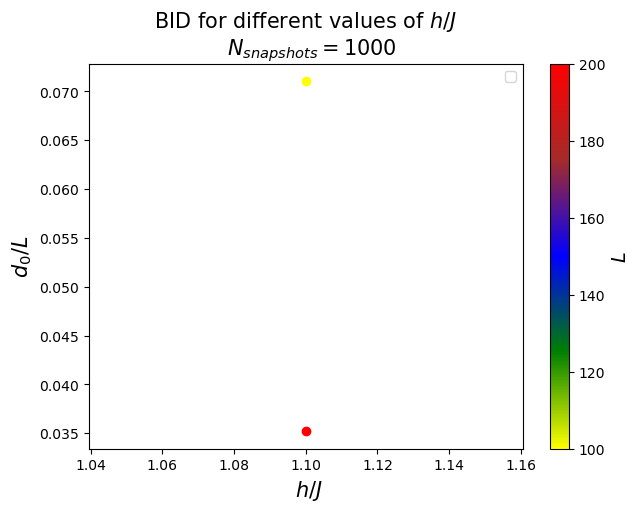

/tmp/ipykernel_5072/2005842934.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axis.legend()


<Figure size 640x480 with 0 Axes>

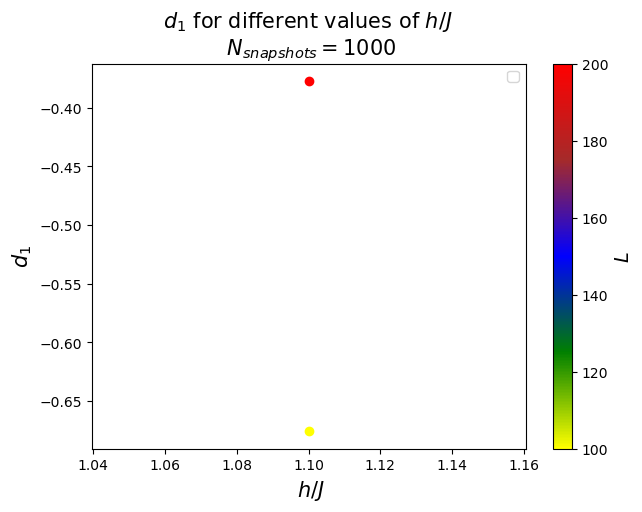

In [52]:
ID0=np.array(ID0)
print(ID0,DID0)
DID0=np.array(DID0)
xx=[0.01*G[a] for a in AA]




plt.figure()
fig,axis=plt.subplots(1,1,figsize=(7,5))
plt.title("BID for different values of $h/J$ \n  $N_{snapshots}="+str(NS)+"$",fontsize=15)
plt.xlabel(" $h/J$",fontsize=15)
plt.ylabel("$d_0/L$",fontsize=15)
for i in range(len(l)):
    axis.errorbar(xx,ID0[i,:,2]/l[i],yerr=DID0[i,:,2]/l[i],linestyle="dashed",color=cmap(norm(l[i])))
    axis.scatter(xx,ID0[i,:,2]/l[i],color=cmap(norm(l[i])))
axis.legend()

sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # ScalarMappable needs an array, even an empty one is fine
cbar = plt.colorbar(sm,ax=axis,label='$L$')
cbar.set_label('$L$', fontsize=14)
plt.savefig("BID"+name_figs)

plt.show()

plt.figure()
fig,axis=plt.subplots(1,1,figsize=(7,5))
plt.title("$d_1$ for different values of $h/J$ \n $N_{snapshots}="+str(NS)+"$",fontsize=15)
plt.xlabel(" $h/J$",fontsize=15)
plt.ylabel("$d_1$",fontsize=15)
for i in range(len(l)):
    axis.errorbar(xx,ID0[i,:,1],yerr=DID0[i,:,1],linestyle="dashed",color=cmap(norm(l[i])))
    axis.scatter(xx,ID0[i,:,1],color=cmap(norm(l[i])))
axis.legend()

sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # ScalarMappable needs an array, even an empty one is fine
cbar = plt.colorbar(sm,ax=axis,label='$L$')
cbar.set_label('$L$', fontsize=14)
plt.savefig("D1"+name_figs)

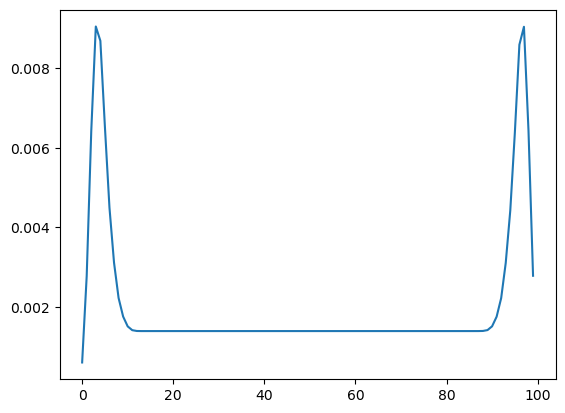

In [49]:
plt.figure()
for L in range(ll):
    plt.plot(DPDF[L][2])

In [44]:
len(DPDF[:][0])

3

In [35]:
ID0

array([], shape=(1, 0), dtype=float64)